# Errro Testing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner

from matplotlib import colormaps
from numpy.random import random
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 13,
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
    "lines.linewidth": 1,
    "lines.markersize": 3,
    "figure.dpi": 300
})

from lib.Model import Model, histMCMC, plotData

## Mean Square Error
define the mean square error (MSE) to be
$$
E_{\rm MSE}\left(\vec{k}\right) = \frac{1}{N}\sum_{i=1}^{2}\sum_{j=0}^{N-1}\left(x_{i,j}-x_{\rm theory,j}\left(\vec{k}\right)\right)^2,
$$
where the experimental position data points are given by
$$
x_{i,j},\quad j=0,1,\ldots, N-1,
$$
where $i=1,2$ denote the two masses position, and $\vec{k}=\left(k_1,k_2,k_3\right)$ denote the spring constant.

Define the probability to be
$$
P\left(\vec{k}\right) = \exp\left(-E_{\rm MSE}\left(\vec{k}\right)^2\right)
$$

## First testing
- using $k_2 = 100$, $k_2 = 120$ and $k_3 = 150$ to be the target spring constant

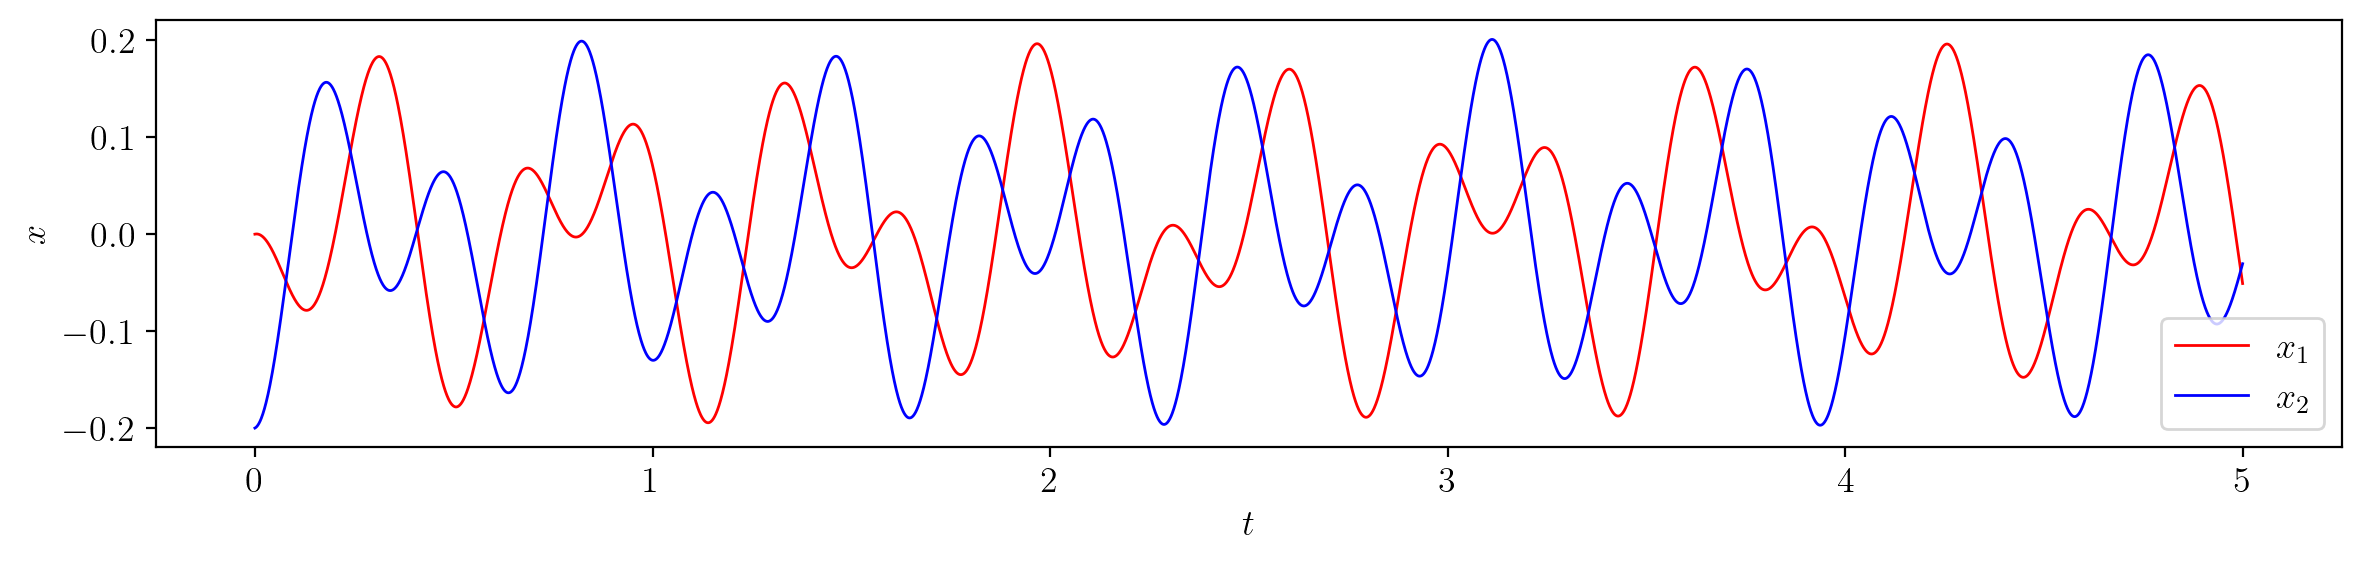

In [12]:
t = np.arange(0, 5, 0.001)
k = (100,120,150)
m = (1.0, 1.0)
xi = (0.0, -0.2)
vi = (0.1, 0.2)
(x1_data, x2_data, v1_data, v2_data) = Model(t, k, m, xi, vi)

plotData(t, x1_data, x2_data)

## Mean Square Error

In [15]:
def P_MSE(t, k, x1_data, x2_data, m, xi, vi):
    N = len(t)
    x1_theo, x2_theo, v1_theo ,v2_theo = Model(t, k, m, xi, vi)
    MSE1 = np.sum((x1_data - x1_theo)**2) / N
    MSE2 = np.sum((x2_data - x2_theo)**2) / N
    P = np.exp(-(MSE1+MSE2))
    return np.exp(2000*(P-1))

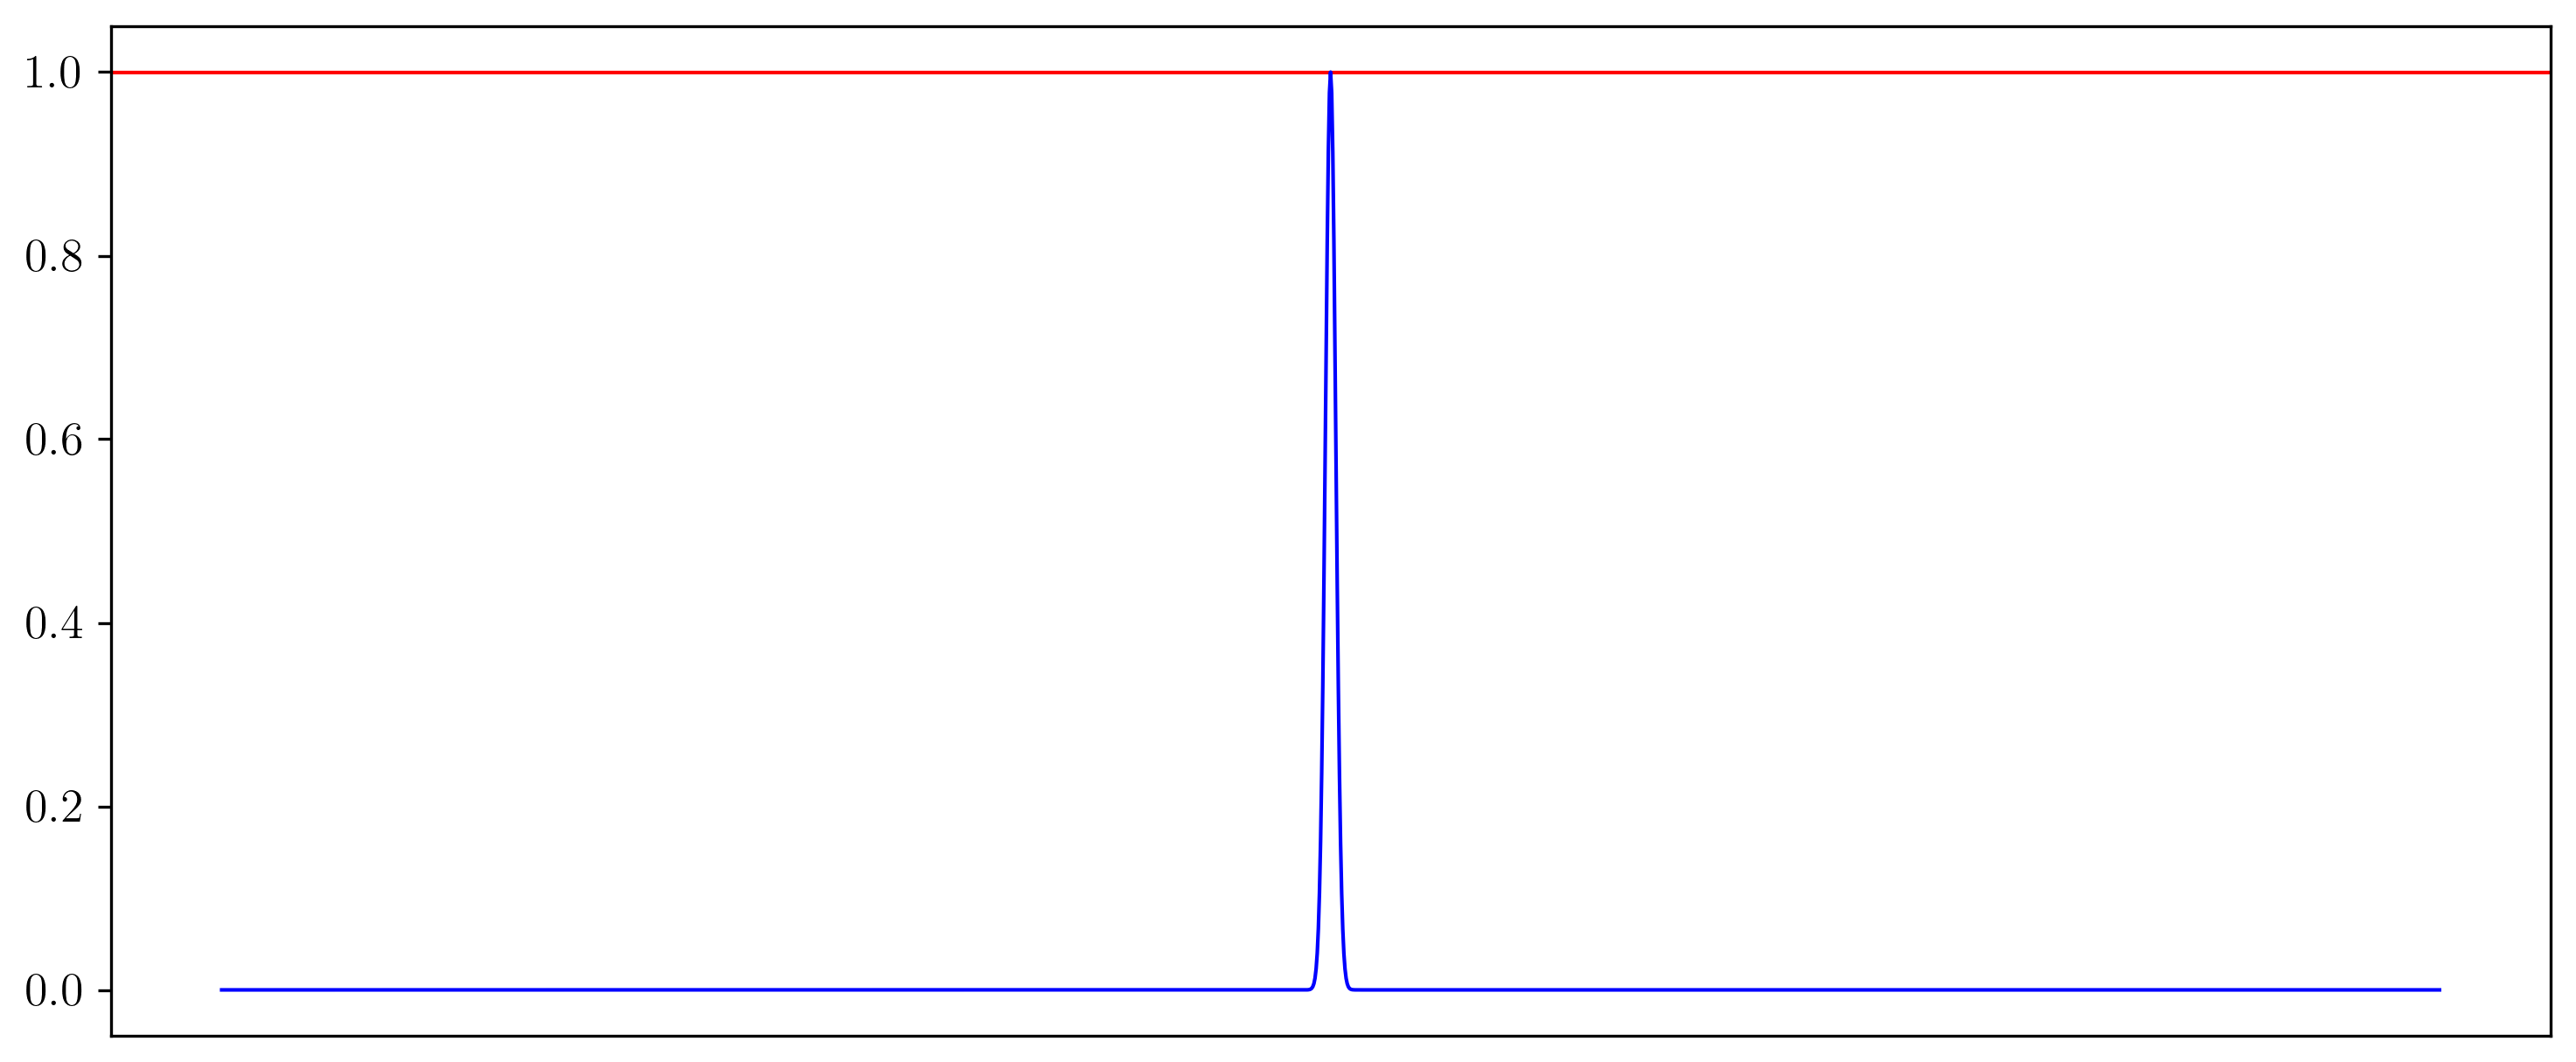

In [16]:
plt.figure(figsize=(12,5))

L = np.linspace(0,1, 1000)

k1 = np.concatenate([L*k[0], k[0]*(1+L[1:])])
k2 = np.concatenate([L*k[1], k[1]*(1+L[1:])])
k3 = np.concatenate([L*k[2], k[2]*(1+L[1:])])

Prob = np.zeros(len(k1))
for i in range(len(k1)):
    Prob[i] = P_MSE(t, (k1[i], k2[i], k3[i]), x1_data, x2_data, m, xi, vi)

plt.axhline(1,color="red")
plt.plot(Prob, color="blue")
plt.xticks([])
plt.show()

In [17]:
N = 20000
Paras = np.zeros([N, 3])
paras = 50 + 50*random(3)

delta = 10
accN = 0
print(paras)
for i in range(1000):
    paras_ = paras + delta * (2*random(3)-1)
    p  = P_MSE(t, paras, x1_data, x2_data, m, xi, vi)
    p_ = P_MSE(t, paras_, x1_data, x2_data, m, xi, vi)
    if(p_ >= p or random() < p_/p): 
        paras = paras_
        accN += 1
acc_rate = accN/1000
print(r"acceptance rate : %.5f"%acc_rate)

accN = 0
print(paras)
for i in range(N):
    paras_ = paras + delta * (2*random(3)-1)
    p  = P_MSE(t, paras, x1_data, x2_data, m, xi, vi)
    p_ = P_MSE(t, paras_, x1_data, x2_data, m, xi, vi)
    if(p_ >= p or random() < p_/p): 
        paras = paras_
        accN += 1
    Paras[i] = paras
acc_rate = accN/N
print(r"acceptance rate : %.5f"%acc_rate)

[65.57899352 75.78078784 63.02275317]
acceptance rate : 0.22700
[ 32.72603542  52.98179028 159.96926564]
acceptance rate : 0.11980


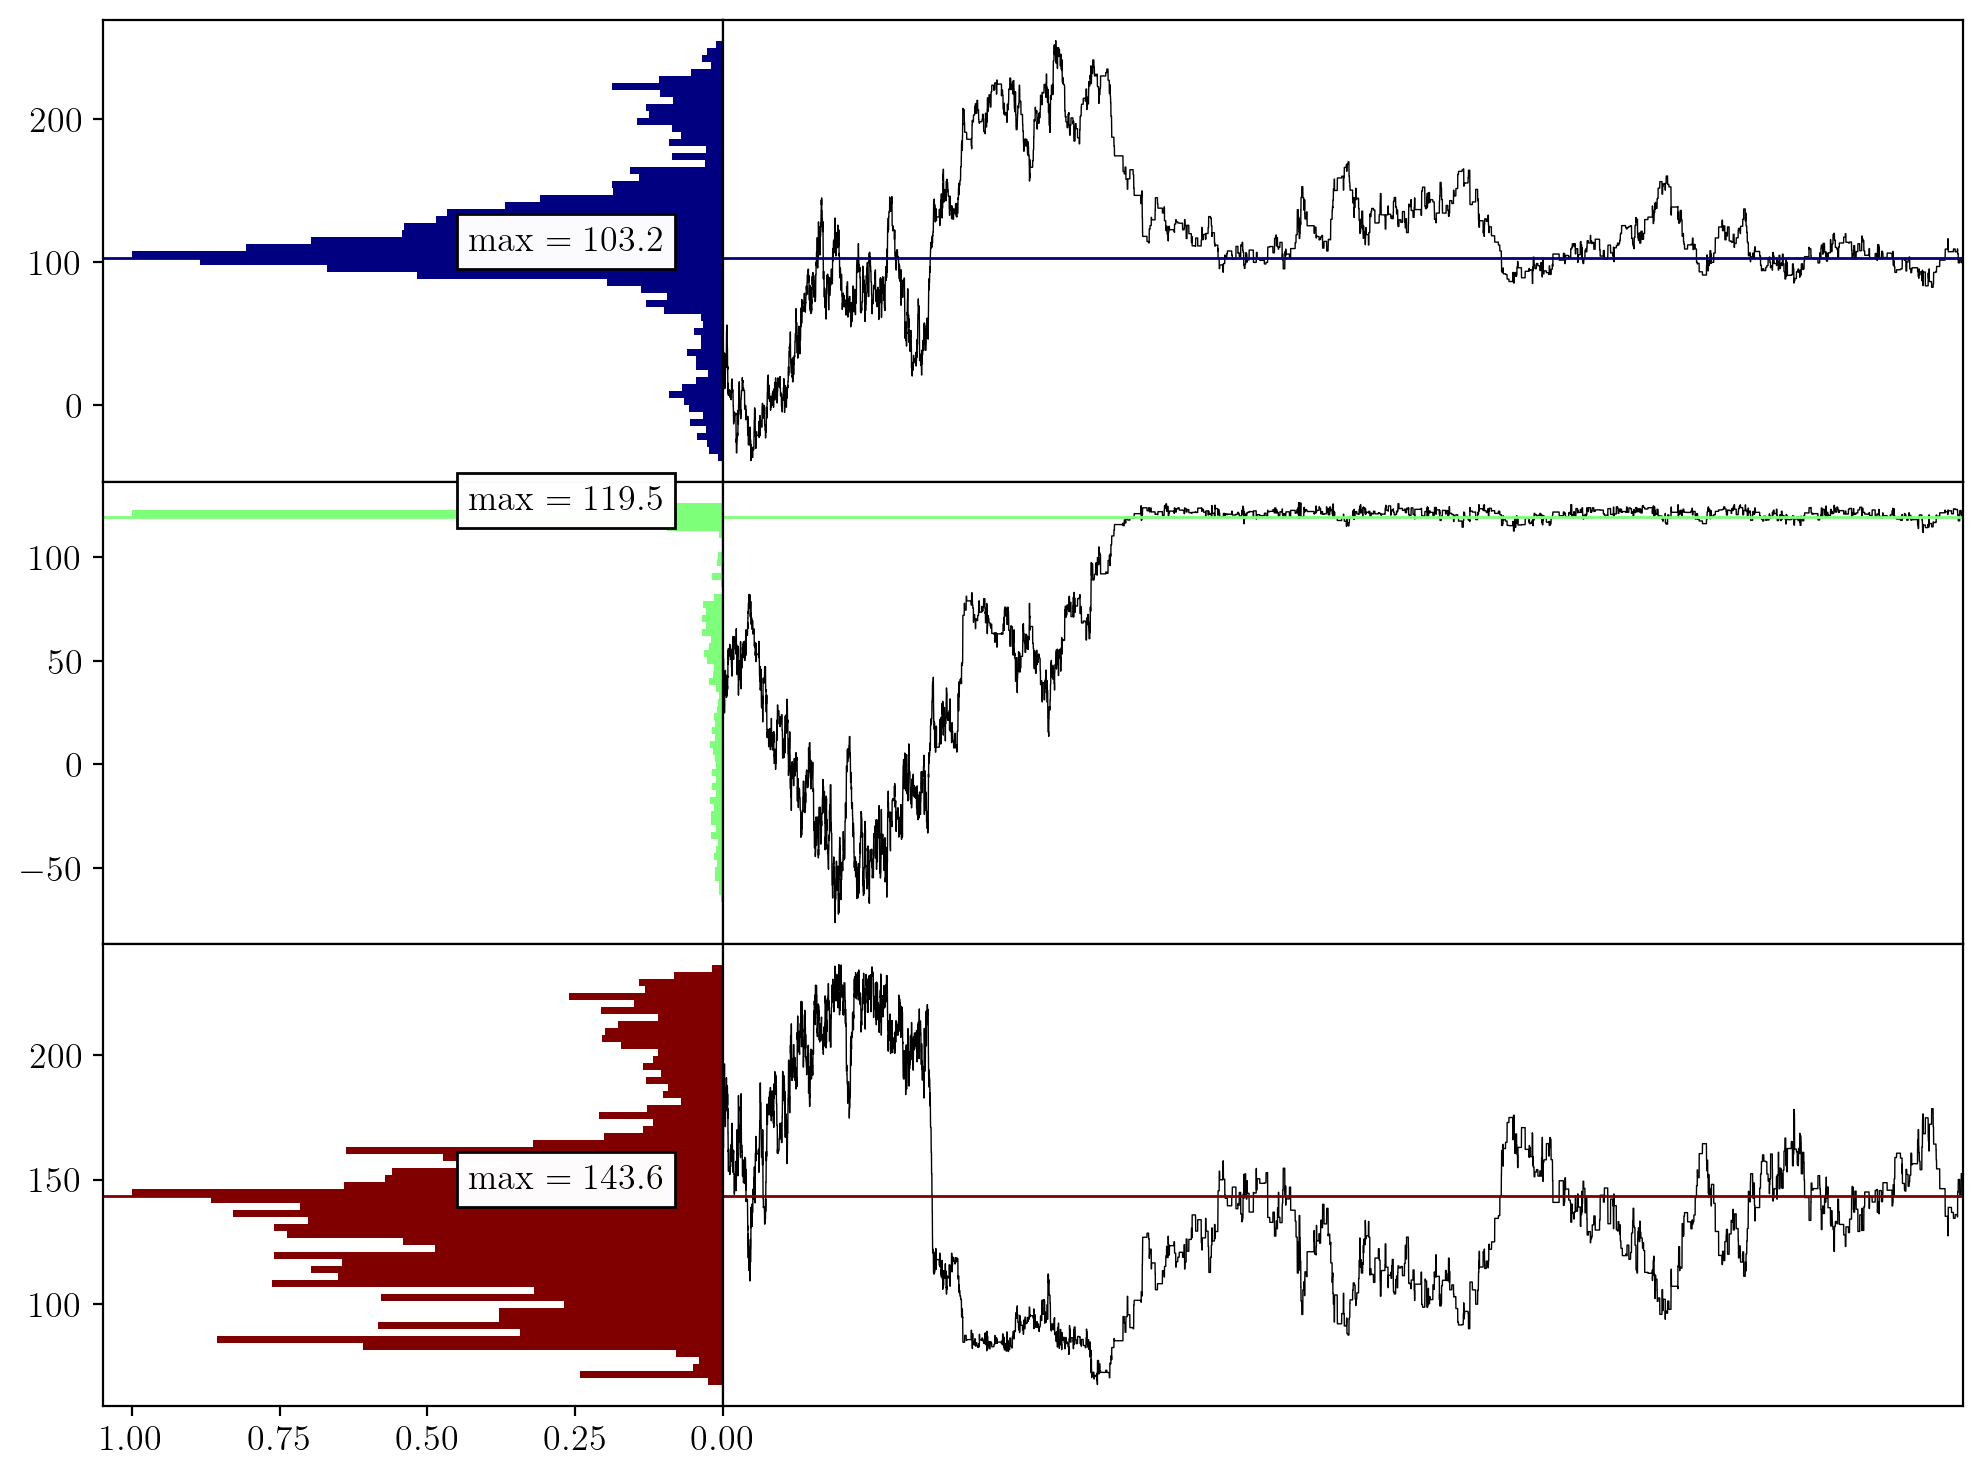

{'max': array([103.23925742, 119.54315119, 143.5531736 ]), 'mean': array([118.54447617,  90.52826741, 136.03863647])}


In [20]:
hist_result = histMCMC(Paras, bins=60)
print(hist_result)

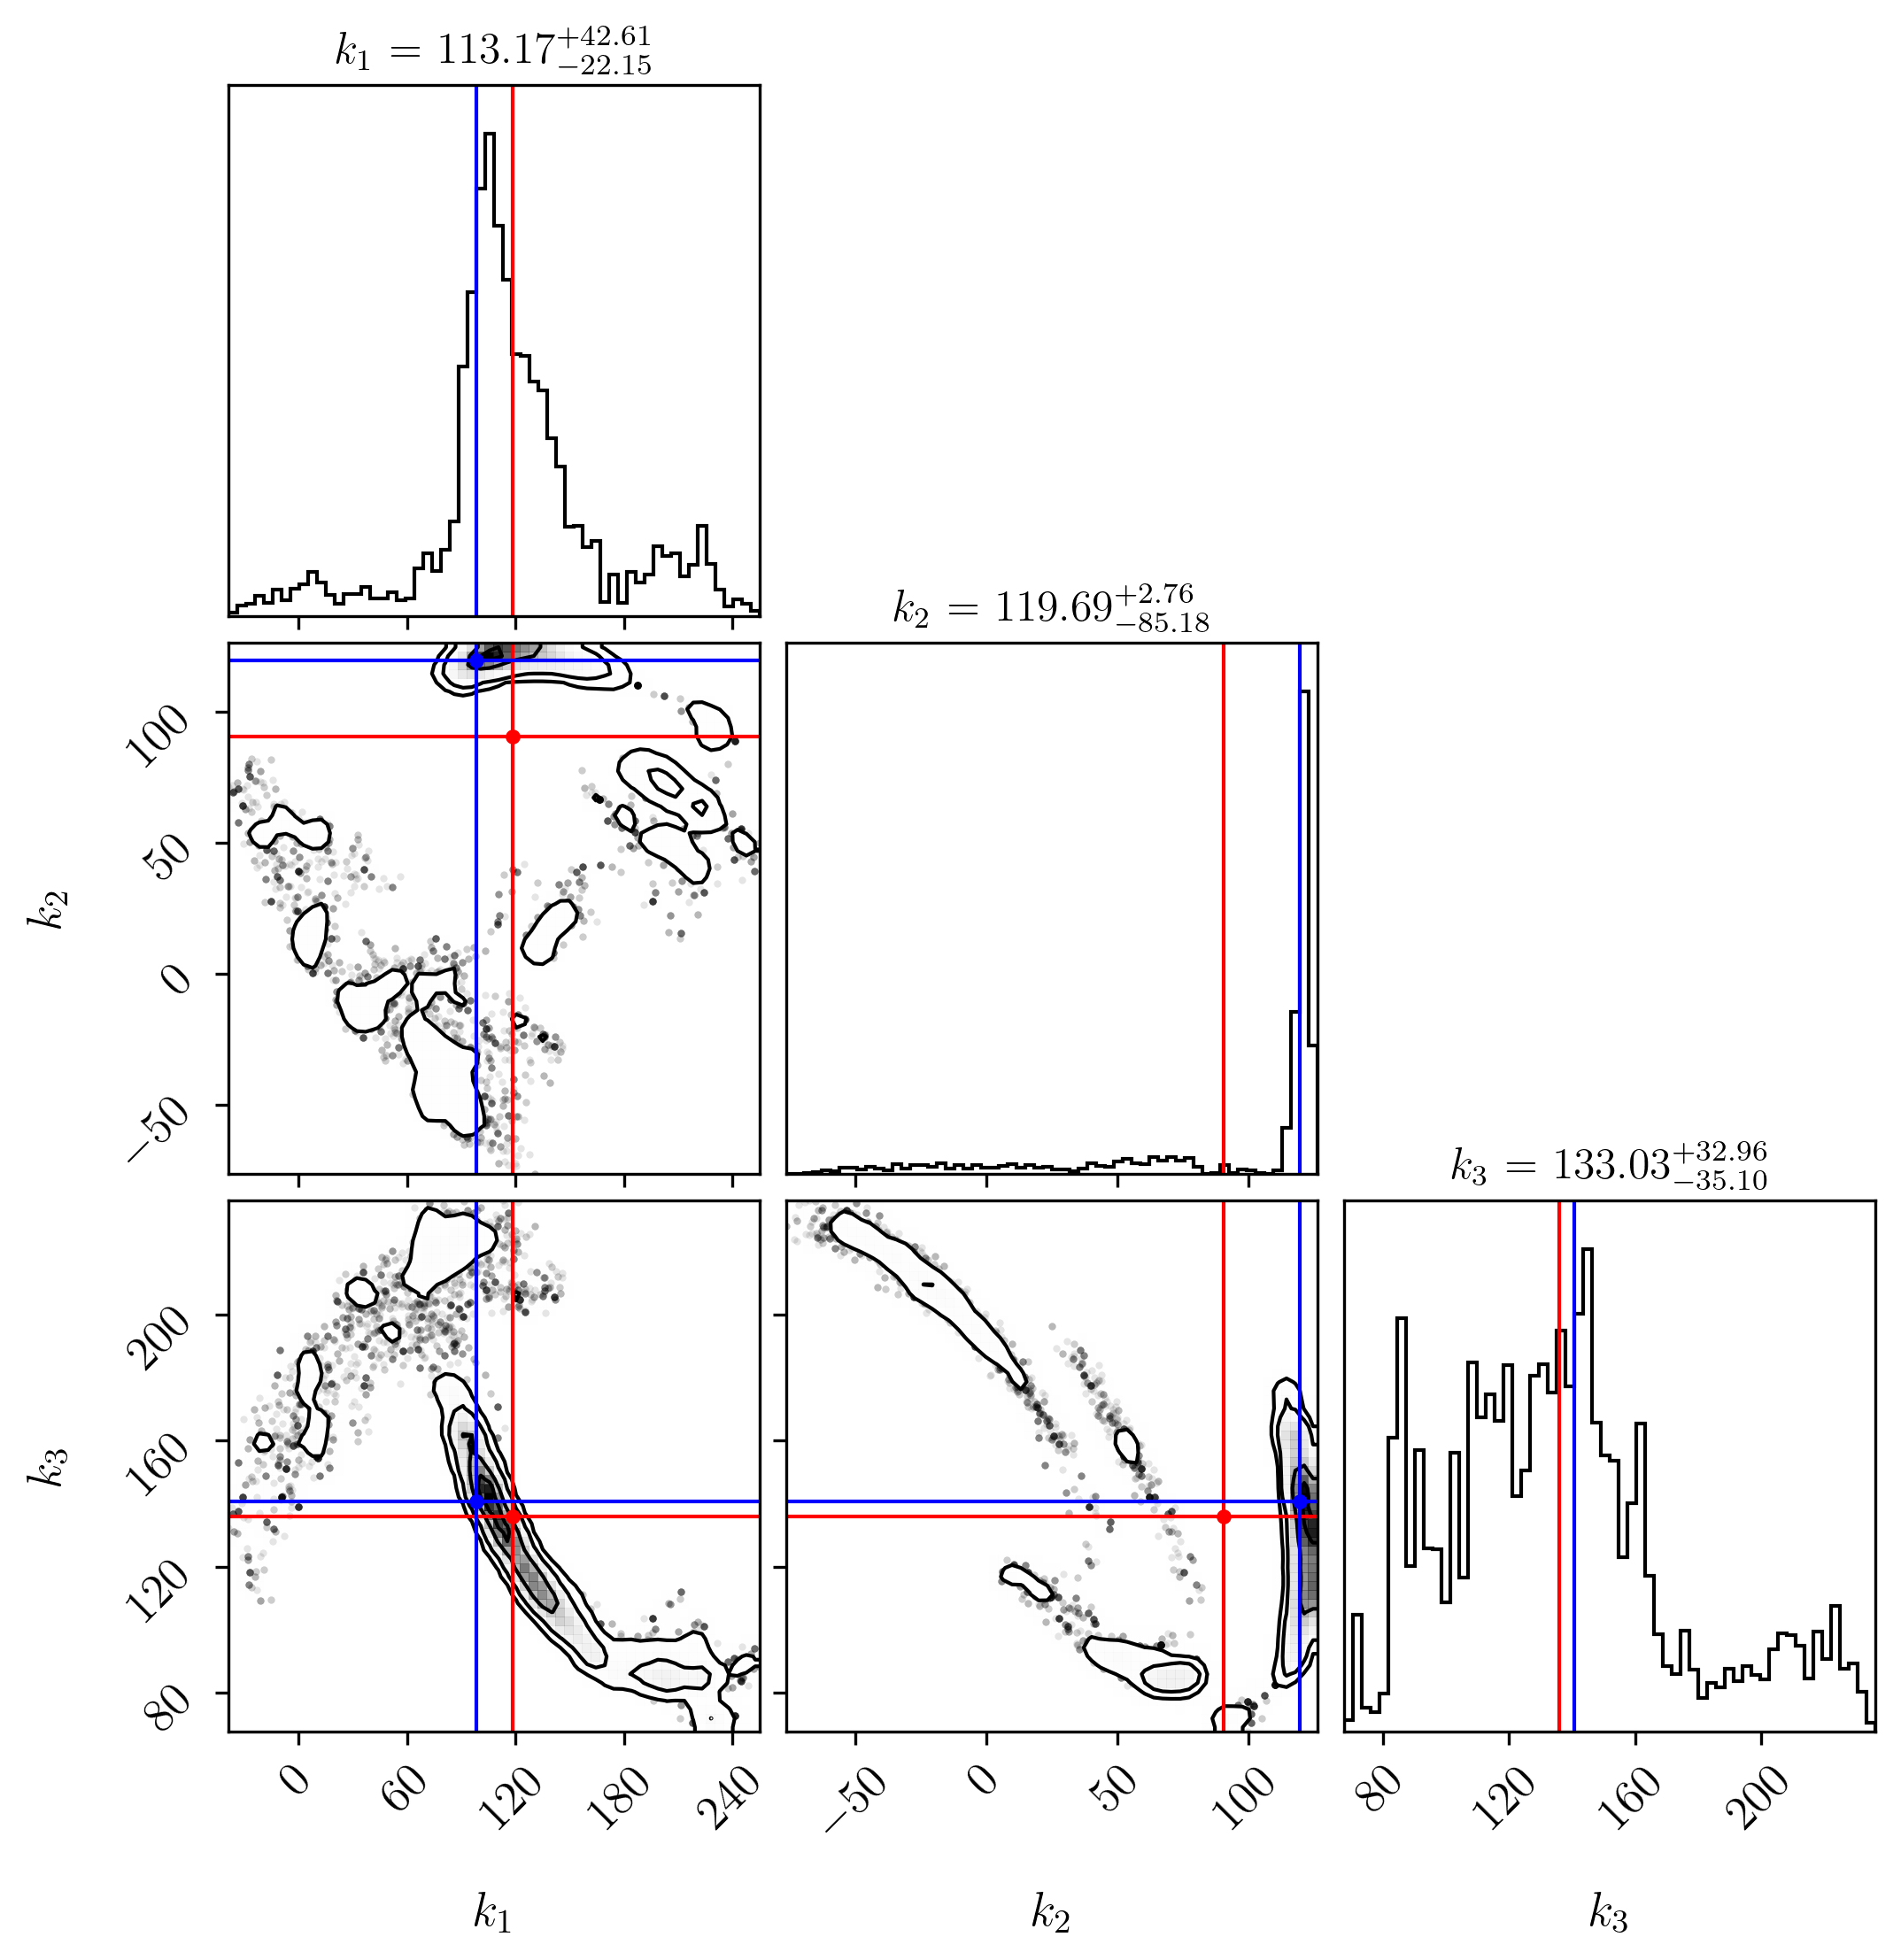

In [19]:
fig = corner.corner(
    Paras, 
    labels=["$k_1$", "$k_2$", "$k_3$"],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    dpi=100,
    smooth=1,
    bins=60
)
corner.overplot_lines(fig, hist_result["mean"], color="red")
corner.overplot_points(fig, hist_result["mean"][None], marker="o", color="red")
corner.overplot_lines(fig, hist_result["max"], color="blue")
corner.overplot_points(fig, hist_result["max"][None], marker="o", color="blue")

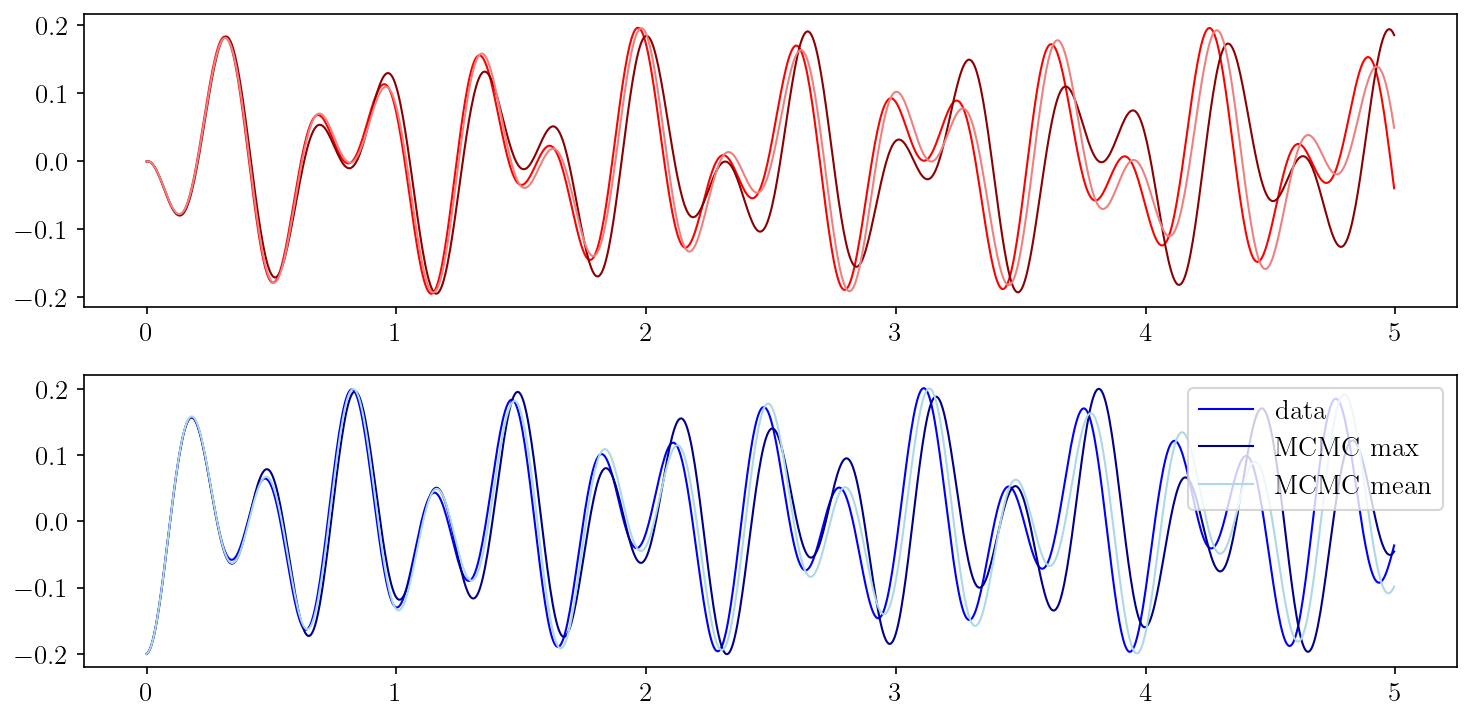

In [11]:
(x1_data_max, x2_data_max, v1_data, v2_data) = Model(t, hist_result["max"], m, xi, vi)
(x1_data_mean, x2_data_mean, v1_data, v2_data) = Model(t, hist_result["mean"], m, xi, vi)

fig,axs = plt.subplots(2,1,figsize=(10,5),dpi=150)
axs[0].plot(t,x1_data, color="red", label=r"data")
axs[1].plot(t,x2_data, color="blue", label=r"data")
axs[0].plot(t,x1_data_max, color="darkred", label=r"MCMC max")
axs[1].plot(t,x2_data_max, color="darkblue", label=r"MCMC max")
axs[0].plot(t,x1_data_mean, color="lightcoral", label=r"MCMC mean")
axs[1].plot(t,x2_data_mean, color="lightblue", label=r"MCMC mean")
plt.legend()
plt.tight_layout()
plt.show()